# VI. Task 1: Cancerous classification <a class="anchor" id="task1"></a>


- Here, we will perform **image classification to detect if a cell is cancerous or not**.
- This part is including data preprocessing, setting up evaluation framework, resampling, train test split and modelling.


## 2. Neural Network <a class="anchor" id="task1nn"></a>


In [52]:
# importing libraries and modules
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import *
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
import hashlib
import pickle as pkl
from collections import defaultdict
from PIL import Image, ImageOps
import seaborn as sns

import keras
from keras.models import *
from keras.layers import *
from keras import backend as K
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping



### Preprocessing


- In task 1, since our target is 'isCancerous' column we will ignore the cellType column for now as we also need more data for the better training process. However, the bigger the dataset size, the better the deep learning process is. Therefore, we need to have more data to prevent the neural network from underfitting and overfitting issues.


In [53]:
cancer_df=pd.read_csv("./converted_data/df_labels_balanced.csv")
converted_data = pd.read_csv('./converted_data/converted_data.csv')
img_dir='./patch_images/'


In [54]:
X_cnn = cancer_df.drop("iscancerous", axis=1)
y_cnn = cancer_df[["iscancerous"]]


- As mentioned in preprocessing section in supervised learning, we will apply the Random Undersampling technique for neural network. As typical neural network models often contains many layers and neuron connections, it will learn the dataset deeply according to the amount of layer of specific model. To have reasonable result, we will prevent the duplication in the training dataset, by not using Over Sampling technique. Instead, the Random UnderSampling technique will be applied for the neural network models.
  Additionally, we when see the mount of `is Cancerous` and not `Cancerous` - 7068 and 13207, respectively. It is reasonable to say that after using Random UnderSampling techniques, we still have a dataset of 14138 records to train with, this is moderated dataset size for training process


In [55]:
rus = RandomUnderSampler(random_state=42)
X_rus_cnn, y_rus_cnn = rus.fit_resample(X_cnn, y_cnn)


In [56]:
X_rus_cnn["iscancerous"] = y_rus_cnn


In [57]:
cancer_df_cnn = X_rus_cnn.copy()
cancer_df_cnn


,imagename,celltype,iscancerous
0,16475.png,0,0
1,17324.png,3,0
2,11878.png,0,0
3,17796.png,3,0
4,17393.png,3,0
...,...,...,...
8121,1625.png,2,1
8122,1626.png,2,1
8123,1627.png,2,1
8124,1628.png,2,1


In [58]:
cancer_df_cnn["iscancerous"].value_counts()


0    4063
1    4063
Name: iscancerous, dtype: int64

In [59]:
cancer_df_cnn["iscancerous"] = cancer_df_cnn["iscancerous"].astype(str)


### Evaluation framework


- Since metrics of Neural Network will be a little bit different from traditional machine learning model. It is necessary to take into consideration epsilon. Therefore, with reference to [this paper](https://github.com/shabbeersh/RCCNet/blob/master/Src/RCCNet.py)


In [60]:
def recall_cnn(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_cnn(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_cnn(y_true, y_pred):
    precision = precision_cnn(y_true, y_pred)
    recall = recall_cnn(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


In [61]:
METRICS = ["accuracy", recall_cnn, precision_cnn, f1_cnn]


- We set up function to visualize the training history of the model


In [72]:
def visualize_history(history):
    #  "Plot Accuracy"
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

    # "Plot Loss"
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


- Since we will use the functions across the model, therefore it is necessary to develop function to work on resuable component.
- Inside this function:

* `epochs_num`: The number of epochs that we use to train the mode
* `Early Stopping`: keras functions in Callbacks to specify the monitor in order to end training. Patience amount is set as 40. This is used to examine plots of performance metric for estimating how noisy the optimization process on data. The mode is set to max, and the metric to keep track is accuracy of validation set. In "max" mode it will stop when the quantity monitored has stopped increasing.
* `Model Check Point`: to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.
  In here we set save_best_only to true :to allow the model is only saved when it is deemed "best," and the most recent best model according to the quantity monitored is not overwritten. In here we also export the model to h5 file and will import it again to evaluate.
* `history`: we fill fit model to training and validation iteration to train a CNN models. Step per epoch will equal the size of corresponding training and validation iteration. We apply callbacks on early stopping and model checkpoint.


In [73]:
def Train_CNN_Model(epochs_num, model, train_iter, valid_iter, export_dir="./export", name="default"):
    # -------------------------------------------------------------------------
    #                        Train CNN Model
    # -------------------------------------------------------------------------

    epochs = epochs_num

    es = EarlyStopping(monitor="val_accuracy", mode="max", verbose=1, patience=40)

    mc = ModelCheckpoint(f"{export_dir}/model_{name}.h5", monitor="val_accuracy", mode="max", save_best_only=True)

    history = model.fit(
        train_iter,
        steps_per_epoch=len(train_iter),
        validation_data=valid_iter,
        validation_steps=len(valid_iter),
        epochs=epochs,
        verbose=1,
        callbacks=[mc, es],
    )

    return history


We also develop evaluation function to evaluate each model, in here we also check for overfitting and underfitting by evaluate the training and validation iteration. After the evaluation we will export the result of each model to the csv file for further evaluation on overall


In [74]:
def Evaluate_CNN_Model(model, test_iter, train_iter, val_iter, model_name):
    # -------------------------------------------------------------------------
    #                        Evaluate CNN Model
    # -------------------------------------------------------------------------

    model_evaluation_test = model.evaluate(test_iter)
    model_evaluation_train = model.evaluate(train_iter)
    model_evaluation_val = model.evaluate(val_iter)

    # metrics = ['accuracy', 'precision', 'recall','f1']
    METRICS_EVAL = ["loss", "accuracy", "recall", "precision", "f1"]
    print("Model Evaluation")
    for i in range(len(METRICS_EVAL)):

        print("----------------------------------------------")

        print(f"{METRICS_EVAL[i]} - test: {model_evaluation_test[i]} ")

        print(f"{METRICS_EVAL[i]} - train : {model_evaluation_train[i]} ")

        print(f"{METRICS_EVAL[i]} - val: {model_evaluation_val[i]} ")

        # we will be using this function to log each model run to a csv file

    run = {
        "model": [model_name],
        "loss_test": [model_evaluation_test[0]],
        "acc_test": [model_evaluation_test[1]],
        "recall_test": [model_evaluation_test[2]],
        "precision_test": [model_evaluation_test[3]],
        "f1_test": [model_evaluation_test[4]],
        "loss_train": [model_evaluation_train[0]],
        "acc_train": [model_evaluation_train[1]],
        "recall_train": [model_evaluation_train[2]],
        "precision_train": [model_evaluation_train[3]],
        "f1_train": [model_evaluation_train[4]],
    }
    try:
        pred_cnn_df = pd.read_csv("prediction_cnn.csv")

        # logging the metrics as a new row in the csv
        pred_cnn_df = pred_cnn_df.append(pd.DataFrame(run), ignore_index=True)
        pred_cnn_df.to_csv("prediction_cnn.csv", header=True, index=False)
    except:
        pd.DataFrame(run).to_csv("prediction_cnn.csv", header=True, index=False)


### Train test split and create data iterator


- In developing Convotional Neural Network (CNN) we will mention in detail below in the CNN architecture. But here, it is necessary to divide the training and testing sets for the data.


In [75]:
from sklearn.model_selection import train_test_split

train_cnn_task1, test_cnn_task1 = train_test_split(cancer_df_cnn, test_size=0.2, random_state=9999)
train_cnn_task1, val_cnn_task1 = train_test_split(train_cnn_task1, test_size=0.25, random_state=9999)


In [76]:
print(f"Training size: {train_cnn_task1.shape[0]}")
print(f"Testing size: {test_cnn_task1.shape[0]}")
print(f"Validation size: {val_cnn_task1.shape[0]}")
print(f"Sum {train_cnn_task1.shape[0]+test_cnn_task1.shape[0] + val_cnn_task1.shape[0]}")

Training size: 4875
Testing size: 1626
Validation size: 1625
Sum 8126


#### Data Augmentation


- Data augmentation is a technique that can be used to artificially increase the size of a training dataset by generating modified versions of the dataset's images.

- Training deep learning neural network models on more data can result in more proficient models, and augmentation approaches can provide variants of the images that increase the fit models' ability to generalize what they have learnt to new images.
- We set:
  - `rescale` to new scale of 1./255
    `shear_range and zoom_range` of 0.2 for shearing and zooming the cell image to 20% bigger.
  - `horizontal flip` flipping the image horizontally to reverse the rows or columns of pixels to make the model have ability to generalize the image to prevent bias.
    - `width and height shift range` is set to 0.2 since we want to move image means for all pixels in one direction while keeping the image dimensions the same.
    - `rotation range` rotating image clockwise by 20 degree, this rotation leaves areas of the frame with no pixel data that must be filled in.
- We will make data augmentation to be used in the generator


In [91]:
train_generator = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=20,
)

test_generator = ImageDataGenerator(rescale=1.0 / 255)


In [92]:
train_iter_t1 = train_generator.flow_from_dataframe(
    dataframe=train_cnn_task1,
    directory="./patch_images",
    x_col="imagename",
    y_col="iscancerous",
    class_mode="categorical",
    target_size=(27, 27),
)

val_iter_t1 = test_generator.flow_from_dataframe(
    dataframe=val_cnn_task1,
    directory="./patch_images",
    x_col="imagename",
    y_col="iscancerous",
    class_mode="categorical",
    target_size=(27, 27),
)

test_iter_t1 = test_generator.flow_from_dataframe(
    dataframe=test_cnn_task1,
    directory="./patch_images",
    x_col="imagename",
    y_col="iscancerous",
    class_mode="categorical",
    target_size=(27, 27),
)


Found 4875 validated image filenames belonging to 2 classes.
Found 1625 validated image filenames belonging to 2 classes.
Found 1626 validated image filenames belonging to 2 classes.


In [93]:
print(f"Image iteration training shape: {train_iter_t1.image_shape}")
print(f"Image iteration testing shape: {test_iter_t1.image_shape}")
print(f"Image iteration validation shape: {val_iter_t1.image_shape}")


Image iteration training shape: (27, 27, 3)
Image iteration testing shape: (27, 27, 3)
Image iteration validation shape: (27, 27, 3)


### Modelling


_Note: All neural networks except RCCNet will be running only 50 epochs to avoiding overtraining, which usually leads to overfitting, and lack of computing power. RCCNet will be running with 100 epochs._


#### RCCNet


RCCNet is a Convolutional Neural Network (CNN)-based architecture that was proposed in 2018. This network's primary goal is to keep the CNN model as simple as possible. The RCCNet model has 1,512,868 learnable parameters, which is significantly less than the popular CNN models AlexNet, CIFAR-VGG, GoogLeNet, and WRN [5]. It is also highly efficient in terms of the training time as compared to deeper and complex networks [5].
RCCNet is more generic and efficient in terms of training time and data overfitting, respectively.

**RCCNet: Advantages and Disadvantages**

> Advantages

1. RCCNet model has the lowest number of trainable parameters, whereas AlexNet has the most [5]

2. Since it is simpler than other models and small enough, it significantly reduces training time

**RCCNet: Architecture**

![RCCNet Architecture](https://i.imgur.com/rYCZnj5.png "RCCNet Architecture")


* `1 st block` two convolutional layers, Conv1 and Conv2 are used just after the input layer. The Conv2 layer is followed by a pooling layer (Pool1) to reduce the spatial dimension by half. Both of conv 1 and 2 have stride and subsampling with the receptive field of 2 x 2 which is the maxpooling after the first block. 

	* The 1st convolutional layer Conv1 produces a 32×32×32 dimensional feature map by convolving 32 filters of dimension 3×3×3. The zero padding by 1 pixel in each direction is done in Conv1 layer to retain the same spatial dimensional feature map. 
	* The Conv2 layer has the 32 filters of dimension 3×3×32 with no padding which produces a 30 × 30 × 32 dimensional feature map and stride of 1. 

	
* `2nd block` two convolutional layers  Conv3 and Conv4 layers are followed by second pooling layer (Pool2). They are call two middle convolutional layers (Conv3 and Conv4).Both have 64 filters of size 3x3

* `3rd block` three fully connected layers, namely FC1,FC2, and FC3 are used . The final three fully connected layers (FC1, FC2, and FC3) have 512, 512, and 4 neurons, respectively. 

* On top of the last fully connected layer FC3 of proposed RCCNet model, a ‘softmax classifier’ for multi-class classification is used to generate the probabilities for each class.

In [94]:
def Build_RCC(h, w, output_no, activation_type, k_size, p_size, padding_mode):
    model = Sequential()
    # First block of RCC is constructed with 2 convolutional blocks. Conv1 is 32 filter with kernel size of 3x3 following by batch normalization.
    # Conv2 is also 32 filters with kernel size of 3x3 following by batch normalization. At the end of the block a max pooling with size of 2x2 to reduce the input dimension with
    model.add(Conv2D(32, kernel_size=(k_size, k_size), activation="relu", padding=padding_mode, input_shape=(h, w, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(k_size, k_size), activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(p_size, p_size)))

    # Second Block of RCC is constructed with 2 convolutional blocks with 64 filter for both with 3x3 kernel size with not padding. At the end of the block, max pooling size of 2x2
    model.add(Conv2D(64, kernel_size=(k_size, k_size), activation="relu", padding=padding_mode))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(k_size, k_size), activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(p_size, p_size)))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(512, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.0001))  # small drop out rate to avoid overfit
    model.add(Dense(output_no, activation=activation_type))

    return model


In [95]:
RCC_model_t1 = Build_RCC(27, 27, 2, "sigmoid", 3, 2, "same")
RCC_model_t1.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 27, 27, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 27, 27, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 25, 25, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                      

In [96]:
%%time
K.clear_session()
adam = Adam(learning_rate=0.00006, beta_1=0.9,
            beta_2=0.999, epsilon=None, amsgrad=False)
RCC_model_t1.compile(loss='binary_crossentropy',
                     optimizer=adam, metrics=METRICS)
rcc_history_t1 = Train_CNN_Model(
    200, RCC_model_t1, train_iter_t1, val_iter_t1, export_dir='./model_result', name="rcc_t1")


Epoch 1/200
153/153 [==============================] - 10s 59ms/step - loss: 0.4275 - accuracy: 0.8234 - recall_cnn: 0.8203 - precision_cnn: 0.8099 - f1_cnn: 0.8144 - val_loss: 0.9445 - val_accuracy: 0.5040 - val_recall_cnn: 0.5050 - val_precision_cnn: 0.5047 - val_f1_cnn: 0.5049
Epoch 2/200
153/153 [==============================] - 4s 24ms/step - loss: 0.3427 - accuracy: 0.8578 - recall_cnn: 0.8544 - precision_cnn: 0.8535 - f1_cnn: 0.8534 - val_loss: 1.1992 - val_accuracy: 0.5040 - val_recall_cnn: 0.5061 - val_precision_cnn: 0.5051 - val_f1_cnn: 0.5056
Epoch 3/200
153/153 [==============================] - 4s 24ms/step - loss: 0.3163 - accuracy: 0.8751 - recall_cnn: 0.8705 - precision_cnn: 0.8695 - f1_cnn: 0.8696 - val_loss: 0.6799 - val_accuracy: 0.6308 - val_recall_cnn: 0.7106 - val_precision_cnn: 0.6229 - val_f1_cnn: 0.6634
Epoch 4/200
153/153 [==============================] - 4s 24ms/step - loss: 0.3095 - accuracy: 0.8751 - recall_cnn: 0.8685 - precision_cnn: 0.8694 - f1_cnn: 0.

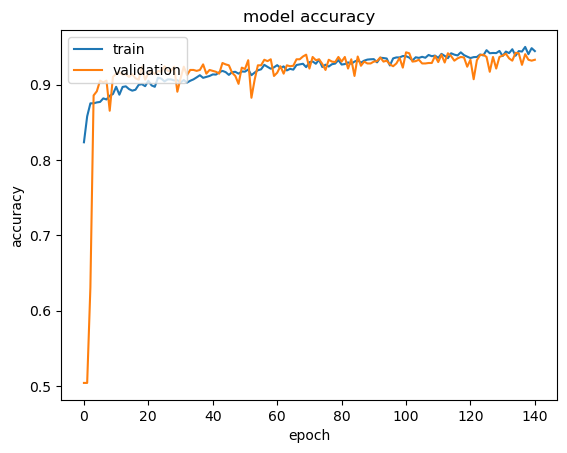

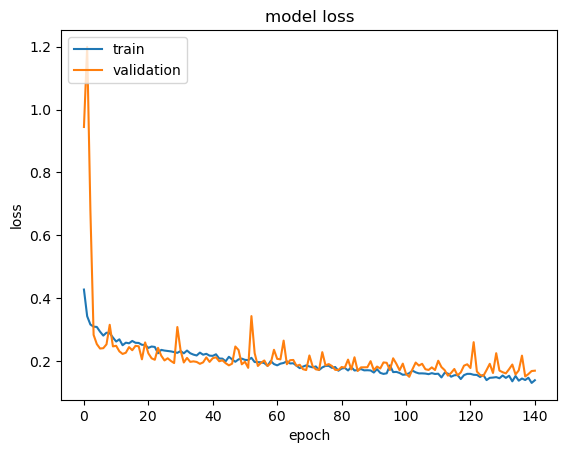

In [97]:
visualize_history(rcc_history_t1)


##### Load model from file and evaluate


In [28]:
RCCNet_model_trained1 = load_model(
    "./model_result/model_rcc_t1.h5",
    custom_objects={"recall_cnn": recall_cnn, "precision_cnn": precision_cnn, "f1_cnn": f1_cnn},
)


In [29]:
Evaluate_CNN_Model(RCCNet_model_trained1, test_iter_t1, train_iter_t1, val_iter_t1, "RCC Net Task 1")


51/51 [==============================] - 1s 10ms/step - loss: 0.1683 - accuracy: 0.9483 - recall_cnn: 0.9473 - precision_cnn: 0.9492 - f1_cnn: 0.9482
Model Evaluation
----------------------------------------------
loss - test: 0.18401867151260376 
loss - train : 0.09642554074525833 
loss - val: 0.1682843416929245 
----------------------------------------------
accuracy - test: 0.9329643249511719 
accuracy - train : 0.9667692184448242 
accuracy - val: 0.9483076930046082 
----------------------------------------------
recall - test: 0.9310897588729858 
recall - train : 0.9657047986984253 
recall - val: 0.9473039507865906 
----------------------------------------------
precision - test: 0.9324603080749512 
precision - train : 0.967363715171814 
precision - val: 0.9491523504257202 
----------------------------------------------
f1 - test: 0.9317014217376709 
f1 - train : 0.9664754271507263 
f1 - val: 0.9481966495513916 


C:\Users\Admin\AppData\Local\Temp\ipykernel_22932\351448186.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_cnn_df = pred_cnn_df.append(pd.DataFrame(run), ignore_index=True)


##### EVALUATION

- `Loss: `The loss values across three sets is not so different from each other just around 0.03 to 0.05, which consider a small amount for neural network model. The loss value for RCC net is one of the smallest value among the models above, which is suitable for our problem here, cancer prediction.
- `Accuracy: `The accuracy for different set is also small when we compare them with each other. Train set is 2% bigger than the test and validation sets. Accuracy for test set and validation are the highest values across the models.
- `Recall: ` Percentage of recall of 92% in testing and validation sets can tell that this model can predict "Of all patients who really have cancer, 92% were predicted to have cancer". This is a very good value, and extremely fit with the problem in the task 1. Since we don't want to miss any patient who is likely to have cancer to be predicted as is not cancer. This will lead to life-threatening scenario, which is extremely dangerous for health care sector. In task 1, we aim to detect as many patient with cancer as possible to prevent death consequence.
- `Precision: ` Percentage of precision of "Of all patients predicted to have cancer, nearly 92% really have cancer”. Since we don't want to mistakenly predict patient who is not likely to have caner as cancerous patient. Since this will lead to hospital's overload in terms of staff, bed and treatment. More important, patient will have side effect when they use drugs and treatment for cancer but they don't really have cancer.
- `F1: ` Since recall and precision is nearly equal each other at 92%, the harmony or them which is F1 score, also stays high at 92%. In our problem, since it is imbalance dataset, we care more about recall, precision and f1 above other metrics.
- `Overall :` RCC Net seems to outperform other models in terms of all metrics, it have the lowest loss value with highest accuracy, recall, precision and f1. This is extremely amazed us, since RCCNet have the smallest amount of layer, but has the highest performance among models. Also, the measurement across training, testing and validation sets shows no potential of overfitting or underfitting in the model. Althought, the measurement of RCC Net is slightly smaller than VGG-16 model in all metrics, but the range is not big e.g accuracy of RCC and VGG-16 on test det are 92.1% and 92.5% - only 0.4% difference. This is a better model compared to VGG-16 since VGG-16 have a complex architecture with many layers and stage, resulting in high complexity and consume huger amount of training time. The trainable parameter for RCC and VGG-16 are `1,151,394` and `33,613,890`, respectively. Comparing trainable parameters of two models' architecture, VGG-16 have more than 33 times of trainable params than RCCNet. The more trainable parameter, the more resource we need for the training process of neural network. For large datasets in healthcare section, VGG will need to more cost of trainings both in terms of time and technologies resource needed.
- `Graph analysis` In addition, the train history of RCCNet shows small gap in loss and accuracy graph. RCCNet also indicates that it slightly fluctuated between training and validation set for loss and accuracy. Both training and testing sets shows a kind of exponential of decreasing in loss and increasing in accuracy in above graphs. This indicate that the model is neither underfitting nor overfitting.
- `Therefore, we consider RCC Net to be our best model for task 1`


## TASK 1 EVALUATION:

- As analysed above, the accuracy graph illustrates that RCCNet architecture has the best accuracy curve where the gap between the training and validation accuracy is minimal compared to all other models architectures. Particularly Alexnet, VGG-16, and ResNet-50 architectures are revealed to exhibit highly fluctuating validation curves, indicating that the architectures are slightly overfit and that some regions of images are classified arbitrarily, thereby generating noise. According to these definitions, RCCNet has the lowest likelihood of overfitting, whereas AlexNet is prone to overfitting because the validation accuracy fluctuates the greatest.
- The loss graph demonstrates that RCCNet has the most acceptable loss curves, since the volatility of validation loss is less pronounced than that of the other networks. At a given point of experience, it is observed that the validation losses of all three structures are increasing (rather than reducing to a point of stability), indicating that the architectures are overfitted. A significant loss fluctuation for ResNet50 and AlexNet may suggest that the validation dataset contains too few instances relative to the training dataset and should be expanded in the future.

**Conclusion:**

- With the supervised machine learning models being extremely overfitted to the training set, therefore, it is safe to infer that RCCNet is the most promising CNN architecture among all 5v-implemented designs for Task 1 and surpasses the supervised machine learning models in every way.


### Preprocessing


In [30]:
converted_data = pd.read_csv('./converted_data/df_labels_balanced_converted.csv')

In [31]:
X = cancer_df.drop("celltype", axis=1)
y = cancer_df[["celltype"]]

In [32]:
X["celltype"] = y
label_df_t2 = X.copy()


In [33]:
label_df_t2 = label_df_t2.drop(["iscancerous"], axis=1)
label_df_t2


,imagename,celltype
0,22405.png,0
1,22406.png,0
2,22407.png,0
3,22408.png,0
4,22409.png,0
...,...,...
16247,13803.png,3
16248,16604.png,3
16249,8687.png,3
16250,12080.png,3


In [34]:
label_df_t2["celltype"].value_counts()


0    4063
1    4063
3    4063
2    4063
Name: celltype, dtype: int64

### Train test split and create data iterator


In [35]:
train_df_task2, test_df_task2 = train_test_split(label_df_t2, test_size=0.2, random_state=1)
train_df_task2, val_df_task2 = train_test_split(train_df_task2, test_size=0.25, random_state=1)


In [36]:
train_df_task2["celltype"] = train_df_task2["celltype"].astype(str)
test_df_task2["celltype"] = test_df_task2["celltype"].astype(str)
val_df_task2["celltype"] = val_df_task2["celltype"].astype(str)


In [38]:
train_generator = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=20,
)

test_generator = ImageDataGenerator(rescale=1.0 / 255)


In [39]:
train_iter_t2 = train_generator.flow_from_dataframe(
    dataframe=train_df_task2,
    directory="./patch_images",
    x_col="imagename",
    y_col="celltype",
    class_mode="categorical",
    target_size=(27, 27),
)

val_iter_t2 = test_generator.flow_from_dataframe(
    dataframe=val_df_task2,
    directory="./patch_images",
    x_col="imagename",
    y_col="celltype",
    class_mode="categorical",
    target_size=(27, 27),
)
test_iter_t2 = test_generator.flow_from_dataframe(
    dataframe=test_df_task2,
    directory="./patch_images",
    x_col="imagename",
    y_col="celltype",
    class_mode="categorical",
    target_size=(27, 27),
)


Found 9750 validated image filenames belonging to 4 classes.
Found 3251 validated image filenames belonging to 4 classes.
Found 3251 validated image filenames belonging to 4 classes.


#### RCC Net task 2


In [40]:
K.clear_session()

model_rcc_t2 = Build_RCC(27, 27, 4, "softmax", 3, 2, "same")
adam = Adam(learning_rate=0.00006, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
model_rcc_t2.compile(loss="categorical_crossentropy", optimizer=adam, metrics=METRICS)
model_rcc_t2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 25, 25, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                        

In [89]:
history_rcc_t2 = Train_CNN_Model(100, model_rcc_t2, train_iter_t2, val_iter_t2, export_dir="./model_result", name="RCC_t2")

Epoch 1/100
305/305 [==============================] - 8s 25ms/step - loss: 0.6355 - accuracy: 0.7518 - recall_cnn: 0.7014 - precision_cnn: 0.7956 - f1_cnn: 0.7447 - val_loss: 0.6965 - val_accuracy: 0.7229 - val_recall_cnn: 0.6864 - val_precision_cnn: 0.7543 - val_f1_cnn: 0.7181
Epoch 2/100
305/305 [==============================] - 7s 24ms/step - loss: 0.6295 - accuracy: 0.7542 - recall_cnn: 0.7061 - precision_cnn: 0.8002 - f1_cnn: 0.7495 - val_loss: 0.6031 - val_accuracy: 0.7635 - val_recall_cnn: 0.7235 - val_precision_cnn: 0.7978 - val_f1_cnn: 0.7583
Epoch 3/100
305/305 [==============================] - 7s 24ms/step - loss: 0.6301 - accuracy: 0.7527 - recall_cnn: 0.7018 - precision_cnn: 0.7962 - f1_cnn: 0.7453 - val_loss: 0.7023 - val_accuracy: 0.7315 - val_recall_cnn: 0.6971 - val_precision_cnn: 0.7615 - val_f1_cnn: 0.7274
Epoch 4/100
305/305 [==============================] - 7s 24ms/step - loss: 0.6140 - accuracy: 0.7588 - recall_cnn: 0.7111 - precision_cnn: 0.8007 - f1_cnn: 0.7

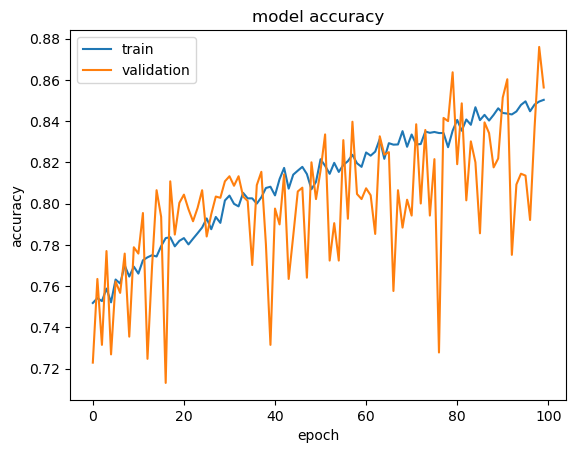

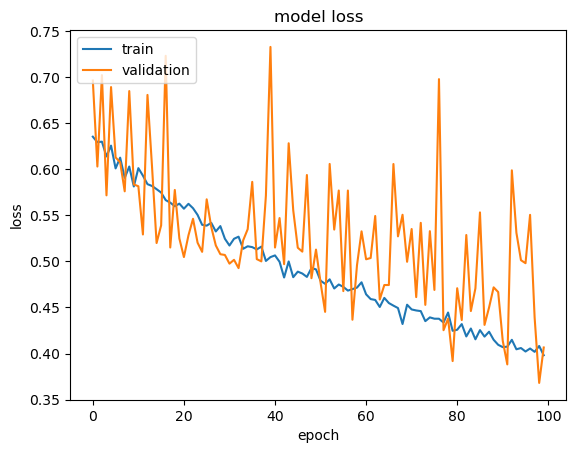

In [90]:
visualize_history(history_rcc_t2)


In [98]:
RCCNet_model_t2 = load_model(
    "./model_result/model_RCC_t2.h5",
    custom_objects={"recall_cnn": recall_cnn, "precision_cnn": precision_cnn, "f1_cnn": f1_cnn},
)



In [99]:
Evaluate_CNN_Model(RCCNet_model_t2, test_iter_t2, train_iter_t2, val_iter_t2, "RCC Task 2")


102/102 [==============================] - 1s 10ms/step - loss: 0.3681 - accuracy: 0.8760 - recall_cnn: 0.8542 - precision_cnn: 0.8931 - f1_cnn: 0.8728
Model Evaluation
----------------------------------------------
loss - test: 0.3998308479785919 
loss - train : 0.3382495045661926 
loss - val: 0.3680887520313263 
----------------------------------------------
accuracy - test: 0.8603506684303284 
accuracy - train : 0.8728204965591431 
accuracy - val: 0.876038134098053 
----------------------------------------------
recall - test: 0.8403637409210205 
recall - train : 0.8450912833213806 
recall - val: 0.8542472720146179 
----------------------------------------------
precision - test: 0.8802827596664429 
precision - train : 0.8960369229316711 
precision - val: 0.8930943012237549 
----------------------------------------------
f1 - test: 0.8595331311225891 
f1 - train : 0.869326114654541 
f1 - val: 0.8728362917900085 


C:\Users\Admin\AppData\Local\Temp\ipykernel_22932\351448186.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_cnn_df = pred_cnn_df.append(pd.DataFrame(run), ignore_index=True)
